# Preprocesamiento de los datos
A continuación se desarrollan algunos preprocesamientos para el dataset completo que se podrán utilizar más adelante para el entrenamiento de los modelos de Machine Learning.

**Todas las funciones que se desarrollan en este notebook se pueden encontrar en el paquete *forecasting_bluesky_code* -> *preprocessing*.**

In [34]:
import pandas as pd
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer

import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

from forecasting_bluesky_code import preprocessing as pre

In [2]:
df = pd.read_csv('final_dataset_bsky_news.csv')

In [3]:
# Relleno de NaN en headlines y date a datetime
df = pre.basic_proc_final_dataset(df)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 701 entries, 2023-05-08 to 2025-04-07
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   artificial intelligence  701 non-null    object 
 1   crime                    701 non-null    object 
 2   education                701 non-null    object 
 3   elections                701 non-null    object 
 4   entertainment            701 non-null    object 
 5   environment              701 non-null    object 
 6   finance                  701 non-null    object 
 7   health                   701 non-null    object 
 8   immigration              701 non-null    object 
 9   international relations  701 non-null    object 
 10  pandemics                701 non-null    object 
 11  politics                 701 non-null    object 
 12  protests                 701 non-null    object 
 13  science                  701 non-null    object 
 14  sports 

### Resumen del dataset semanal
Tras el EDA se decide reducir los registros de nuestro dataset a registros semanales (con posibilidad de cambio de periodo):
- Tot_users: el máximo de esa semana
- New_users: la diferencia de una semana a otra
- Activity features: la media de la semana
- Agrupación del texto de todas las noticias ocurridas esa semana


In [230]:
# Sacamos las medias semanales de las variables de actividad
activity_cols = ['num_likes', 'num_posts', 'num_images', 'num_follows', 'num_blocks']

weekly_activity = df[activity_cols].resample('W').mean()

In [196]:
weekly_users = df[['tot_users']].resample('W').last()

In [208]:
# Agrupamos las noticias por semana

# Separamos las columnas categóricas
num_ft = df._get_numeric_data().columns
cat_ft = df.drop(columns=num_ft).columns

# Creamos un nuevo dataframe con los textos agrupados semanalmente
weekly_news = df[cat_ft].resample('W').agg(lambda x: ' '.join(x.dropna()))

In [236]:
weekly_df = pd.concat([weekly_news, weekly_activity, weekly_users], axis=1)
weekly_df['new_users'] = weekly_df['tot_users'].diff()
weekly_df['new_users'] = weekly_df['new_users'].fillna(0)

In [22]:
def generate_weekly_df(df, period = 'W'):
    '''Receives a daily dataframe and a preferred period (Weekly by default).
    Returns the aggregated dataframe:
    - Activity columns: mean
    - Total Users: last period record
    - New users: difference week-to-week
    - News: text aggregated by period
    '''

    df = df.set_index('date')

    # Activity cols mean
    activity_cols = ['num_likes', 'num_posts', 'num_images', 'num_follows', 'num_blocks']
    activity = df[activity_cols].resample(period).mean()

    # Weekly total users
    users = df[['tot_users']].resample(period).last()

    # Aggregated news
    num_ft = df._get_numeric_data().columns
    cat_ft = df.drop(columns=num_ft).columns
    news = df[cat_ft].resample(period).agg(lambda x: ' '.join(x.dropna()))

    # Concat
    new_df = pd.concat([news, activity, users], axis=1)

    # New_users
    new_df['new_users'] = new_df['tot_users'].diff()
    new_df['new_users'] = new_df['new_users'].fillna(0)

    return new_df

In [24]:
weekly = generate_weekly_df(df)

### Categorización de actividad con PCA
Tras el EDA, y debido a que todas las variables de actividad presentan una fuerte correlación y distribuciones muy similares, se decide unificarlas usando PCA (*Principal Components Analysis*)

Las variables de actividad son ('num_likes', 'num_posts', 'num_images', 'num_follows', 'num_blocks').
1. Normalizar las variables de actividad usando el StandarScaler
2. Aplicamos el PCA a las variables normalizadas y creamos una nueva columna.
3. Esto nos permite reducir la dimensionalidad pero conservar la varianza explicada

In [143]:
# Seleccionamos las columnas de actividad
activity_cols = ['num_likes', 'num_posts', 'num_images', 'num_follows', 'num_blocks']

# Las analizamos
df[activity_cols].describe()

,num_likes,num_posts,num_images,num_follows,num_blocks
count,7.010000e+02,7.010000e+02,7.010000e+02,7.010000e+02,7.010000e+02
mean,9.725748e+06,1.843064e+06,3.750520e+05,3.629630e+06,1.875857e+05
std,1.210714e+07,1.914832e+06,4.010903e+05,6.798539e+06,3.114863e+05
min,2.700000e+02,2.000000e+02,1.500000e+01,2.690000e+02,0.000000e+00
25%,2.429489e+06,6.330000e+05,1.252690e+05,2.269690e+05,2.396100e+04
50%,3.089344e+06,8.280110e+05,1.696380e+05,5.064140e+05,4.124500e+04
75%,1.486084e+07,3.350952e+06,5.900160e+05,4.110857e+06,1.727000e+05
max,4.515699e+07,7.533473e+06,1.679585e+06,4.716763e+07,1.569325e+06


In [145]:
# Normalización estándar (media 0, std 1)
scaler = StandardScaler()
norm_activity = scaler.fit_transform(df[activity_cols])

In [147]:
# Aplicamos el PCA
pca = PCA(n_components=1)
df['activity_score_pca'] = pca.fit_transform(norm_activity)

In [149]:
# Se eliminan las variables que ahora no aportan información
df.drop(columns = (activity_cols), inplace=True)

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     701 non-null    datetime64[ns]
 1   africa                   701 non-null    object        
 2   artificial_intelligence  701 non-null    object        
 3   asia                     701 non-null    object        
 4   bluesky                  701 non-null    object        
 5   china                    701 non-null    object        
 6   election                 701 non-null    object        
 7   europe                   701 non-null    object        
 8   general                  701 non-null    object        
 9   politics                 701 non-null    object        
 10  referendum               701 non-null    object        
 11  science                  701 non-null    object        
 12  spain                    701 non-nul

### Categorización binaria de noticias
0 - no hay noticia ese día 

1 - hay noticia ese día

In [120]:
def binary_news_categorization(df):
    # Numeric & Categoric Features
    num_ft = df._get_numeric_data().columns
    cat_ft = df.drop(columns=list(num_ft)+['date']).columns
    
    for col in cat_ft:
        df[col] = df[col].apply(lambda x: 1 if x != '' else 0)
    
    return df

In [122]:
df = binary_news_categorization(df)

### Stemming
Recortamos las palabras a su raíz con el objetivo de reducir el número de palabras de nuestro dataset y tratar de unificar el léxico.

In [61]:
def stemming(headline):
    '''Función que normaliza y stemmiza un titular. 
    Devuelve el titular en una frase con todas las palabras normalizadas y stemmizadas'''

    # Objeto de Stemming
    stemmer = PorterStemmer()
    
    # Tokenizing the headline
    headline = nltk.tokenize.RegexpTokenizer("[\\w]+").tokenize(headline)
    
    # Word over 2 characters list
    headline = [word for word in headline if len(word)>=3]

    # Stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    
    # Stopwords
    headline = [word for word in headline if word not in stopwords]

    # STEMMING
    headline = [stemmer.stem(word) for word in headline]
    
    # Join each word in a phrase
    headline = " ".join(headline)
    
    return headline

In [99]:
def apply_stem_lemm(df, function):
    '''Applies stemming to every text of a dataframe. Returns the dataframe complete.
    Function: "stem" for stemming / "lem" for lemmatizing'''
    
    # Categoric & Numeric Features
    num_ft = df._get_numeric_data().columns
    cat_ft = df.drop(columns=list(num_ft)+['date']).columns

    if function == 'stem':
        for cat in cat_ft:
            df[cat] = df[cat].apply(stemming)
    
    elif function == 'lem':
        for cat in cat_ft:
            df[cat] = df[cat].apply(lemmatizer)

    else:
        print('Function must be: "stem" for stemming / "lem" for lemmatizing')

    return df

In [103]:
df_stem = apply_stem_lemm(df, 'stem')

In [67]:
df_stem

,date,africa,artificial_intelligence,asia,bluesky,china,election,europe,general,politics,referendum,science,spain,sports,us,videogames,tot_users,new_users,activity_score_pca
0,2023-05-08,,,,,,,,,,,,,the tradit golf intern winner steve stricker,,,31522.0,0.0,-1.650371
1,2023-05-09,,,,,,,,cyclon mocha form indian ocean kill 400 peopl ...,,,,,,,,33644.5,2122.5,-1.644322
2,2023-05-10,,,,,,karnataka legisl assembl elect,,,,,,,2023 italian open tenni intern winner men dani...,,,35767.0,2122.5,-1.647769
3,2023-05-11,,,,,,,,the world health organ end declar mpox global ...,,,the discoveri new moon saturn report take tota...,,,presid biden formal end declar covid pandem co...,,37889.5,2122.5,-1.649415
4,2023-05-12,,,,,,,,,,,,,2023 basketbal champion leagu final four baske...,the titl expuls polici expir midnight creat qu...,,40012.0,2122.5,-1.646652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,2025-04-03,,,,,three filipino nation arrest beij suspicion sp...,,,hungari withdraw intern crimin court isra prim...,,,,,2025 afc asian cup associ footbal continent wi...,,,33995137.0,90941.0,2.993873
697,2025-04-04,,,,,,,,impeach yoon suk yeol the constitut court kore...,,,,,,,,34177832.0,182695.0,3.828071
698,2025-04-05,,,,,,,,over 400 protest event occur across unit state...,,,,,,hand off protest mass protest held citi across...,,34320771.0,142939.0,3.598483
699,2025-04-06,,,,,,,,,,,,,2025 japanes grand prix formula race intern wi...,ice hockey washington capit star alexand ovech...,,34452077.0,131306.0,3.601917


### Lemmatizing


In [88]:
def lemmatizer(headline):
    '''Headline lemmatizer. Receiveis a phrase and returns the phrase lemmatized word by word'''

    # Objeto de Lemmatizing
    wordnet_lemmatizer = WordNetLemmatizer()
    
    # Tokenizing the headline
    headline = nltk.tokenize.RegexpTokenizer("[\\w]+").tokenize(headline)
    
    # Word over 2 characters list
    headline = [word for word in headline if len(word)>=3]

    # Stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    
    # Stopwords
    headline = [word for word in headline if word not in stopwords]

    # LEMMATIZING
    new_tokens=[] # lemmatized
    tag_dict = {"J": wordnet.ADJ, # adjective (a)
                "N": wordnet.NOUN, # name (n)
                "V": wordnet.VERB, # verb (v)
                "S": wordnet.ADJ_SAT, # satellite adjectives (s)
                "R": wordnet.ADV} # adverb (r)

    # Tuples list (ex: [('Laura', 'NNP'), ('teachs', 'VBZ'), ('math', 'NN')])
    words_and_pos = nltk.pos_tag(headline)

    for items in words_and_pos:
        pos = tag_dict.get(items[1][0], wordnet.NOUN) # if not found = name
        new_tokens.append(wordnet_lemmatizer.lemmatize(items[0], pos))
    
    # Join each word in a phrase
    headline_lem = " ".join(new_tokens)
    
    return headline_lem

In [105]:
df_lem = apply_stem_lemm(df, 'lem')

### Preprocesamiento de los headline usando NLP con TF-IDF
Queremos vectorizar nuestros headlines para que el modelo de machine learning pueda trabajar con ellos. Para ello vamos a utilizar el TF-IDF (*Term Frecuency - Inverse Document Frecuency*).

In [9]:
# Numeric Features
num_ft = df._get_numeric_data().columns

In [11]:
# Categorical Features
cat_ft = df.drop(columns=list(num_ft)).columns

In [13]:
cat_ft, num_ft

(Index(['artificial intelligence', 'crime', 'education', 'elections',
        'entertainment', 'environment', 'finance', 'health', 'immigration',
        'international relations', 'pandemics', 'politics', 'protests',
        'science', 'sports', 'technology', 'videogames', 'war'],
       dtype='object'),
 Index(['tot_users', 'new_users', 'num_likes', 'num_posts', 'num_images',
        'num_follows', 'num_blocks'],
       dtype='object'))

In [15]:
# Limpieza básica del texto de todas las noticias (espacios, puntuación y NaN)
for column in cat_ft:
    df[column] = df[column].apply(pre.text_cleaning)

In [17]:
# Creamos una columna que unifique todo el texto de todas las noticias
df['full_text'] = df[cat_ft].agg(" ".join, axis=1)

In [19]:
# Crear el pipeline de procesamiento de texto
vectorizer = Pipeline([
    ('bow', CountVectorizer(max_features=1000, stop_words='english', ngram_range=(1,2), max_df=0.99)), # Bag-of-Words
    ('tfidf', TfidfTransformer()) # TF-IDF
])

# Ajustar y transformar el texto
X_tfidf = vectorizer.fit_transform(df['full_text'])

# Convertir a DataFrame 
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.named_steps['bow'].get_feature_names_out())

In [21]:
# Concatenamos con el resto de datos 
df_final = pd.concat([df[['tot_users', 'new_users']], tfidf_df], axis=1)

In [23]:
### BAG OF WORDS 

# Obtener las palabras (features)
words = vectorizer.named_steps['bow'].get_feature_names_out()

# Calcular el peso promedio de cada palabra a lo largo de todos los documentos
tfidf_means = X_tfidf.mean(axis=0).A1  # .A1 convierte matriz sparse en array 1D

# Crear diccionario {palabra: peso promedio}
tfidf_scores = dict(zip(words, tfidf_means))

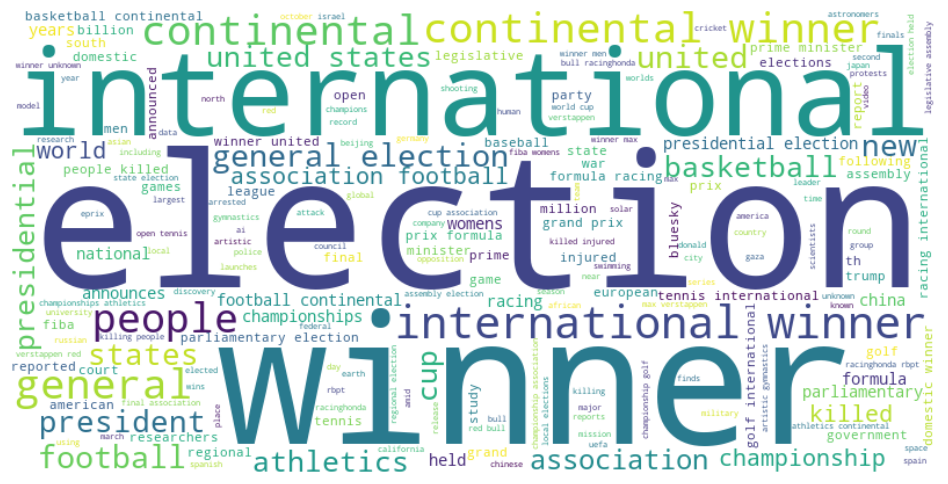

In [38]:
### NUBE DE PALABRAS

# Crear nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_scores)

# Mostrar el plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.savefig('Categories by Frequency', dpi=300, bbox_inches='tight')

plt.show()

### Creación de nuevas columnas para las series temporales
- **Lags**: valor del día anterior para capturar efecto de lo que pasó ayer (aplicamos a todas las variables lineales).
- **Rolling Mean**: promedio de los últimos 7 días para capturar tendencias y suavizar picos (aplicamos solo a new_users y activity porque users es el valor agregado).
- **Diferencias diarias**: calculamos la diferencia de nuevos usuarios y actividad de un día a otro.

In [35]:
# Definimos la columna date como índice del dataset
df_final = df_final.set_index('date').sort_index()

In [37]:
# Lags
df_final['users_lag1'] = df_final['users'].shift(1)
df_final['new_users_lag1'] = df_final['new_users'].shift(1)
df_final['activity_lag1'] = df_final['activity_score_pca'].shift(1)

# Rolling mean
df_final['new_users_ma7'] = df_final['new_users'].rolling(window=7).mean()
df_final['activity_ma7'] = df_final['activity_score_pca'].rolling(window=7).mean()

In [39]:
# Diff
df_final['new_users_diff'] = df_final['new_users'].diff()
df_final['activity_diff'] = df_final['activity_score_pca'].diff()

In [43]:
# Se completan los NaN generados por los rolling etc con 0
df_final = df_final.fillna('0')

,tot_users,new_users,activity_score_pca,accused,accusing,achieve,acquire,acquired,acquisition,act,...,york,york city,zealand,users_lag1,new_users_lag1,activity_lag1,new_users_ma7,activity_ma7,new_users_diff,activity_diff
date,,,,,,,,,,,,,,,,,,,,,
2023-05-08,31522.0,0.0,-1.650371,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-09,33644.5,2122.5,-1.644322,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,-1.650371,NaN,NaN,2122.5,0.006049
2023-05-10,35767.0,2122.5,-1.647769,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,2122.5,-1.644322,NaN,NaN,0.0,-0.003446
2023-05-11,37889.5,2122.5,-1.649415,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,2122.5,-1.647769,NaN,NaN,0.0,-0.001646
2023-05-12,40012.0,2122.5,-1.646652,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,2122.5,-1.649415,NaN,NaN,0.0,0.002763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-03,33995137.0,90941.0,2.993873,0.177576,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,47100.0,2.729988,44293.142857,2.482465,43841.0,0.263885
2025-04-04,34177832.0,182695.0,3.828071,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,90941.0,2.993873,66167.000000,2.688012,91754.0,0.834198
2025-04-05,34320771.0,142939.0,3.598483,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,182695.0,3.828071,82036.571429,2.894282,-39756.0,-0.229588


### Categorización de actividad por quantiles
- Usando una clasificación de 0 a 3 (bajo, medio, alto, muy alto)

In [130]:
def categorize_quantile(var, quantile_num = [0.25, 0.5, 0.75]):
    '''Receives a dataframe column (var) and a list of 3 quantile (optional).
    Returns new column with categorization applied'''

    quantile = var.quantile(quantile_num)
    
    def categorize_score(score):
        if score <= quantile[quantile_num[0]]:
            return 0 # low
        elif score <= quantile[quantile_num[1]]:
            return 1 # medium
        elif score <= quantile[quantile_num[2]]:
            return 2 # high
        else:
            return 3 # very high

    df['new_category'] = var.apply(categorize_score)
    
    return df['new_category']


### Categorización binaria de nuevos usuarios
- Se establece un threshold de 2 semanas para categorizar los nuevos usuarios que quedan por encima de la media

In [ ]:
def categorize_new_user_threshold(df, var = 'new_users'):
    '''Receives full dataframe and a var name (optional).
    Return df with new column: new_users_above_avg.
    Applies a threshold using 2 weeks previus mean.'''
    
    # Rolling mean 14 previus dais (except current day)
    df['mean_prev_14'] = df['new_users'].shift(1).rolling(window=14).mean()
    
    # Target var
    df['new_users_above_avg'] = (df['new_users'] > df['mean_prev_14']).astype(int)

    # Fill first NaN values with 0
    df['new_users_above_avg'] = df['new_users_above_avg'].fillna(0)

    return df

### Zero-Shot Classification
- Clasificación de las noticias por *subject* a través de un modelo de NLP.
- El objetivo es mejorar la clasificación obtenida de Wikipedia usando un modelo preentrenado de NLP.
- Usamos el modelo de zero-shot-classification *facebook/bart-large-mnli* que es el más usado en lengua inglesa. https://huggingface.co/facebook/bart-large-mnli

##### Pruebas

In [86]:
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

text = "The government has announced new AI regulations that could affect the tech industry."

candidate_labels = ["politics", "technology", "artificial intelligence", "sports", "entertainment"]

result = classifier(text, candidate_labels)
print(result)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


{'sequence': 'The government has announced new AI regulations that could affect the tech industry.', 'labels': ['technology', 'artificial intelligence', 'politics', 'entertainment', 'sports'], 'scores': [0.6133959889411926, 0.37737569212913513, 0.004252838436514139, 0.002577610779553652, 0.002397940494120121]}


In [95]:
df_text.columns

Index(['africa', 'artificial_intelligence', 'asia', 'bluesky', 'china',
       'election', 'europe', 'general', 'politics', 'referendum', 'science',
       'spain', 'sports', 'us', 'videogames'],
      dtype='object')

In [97]:
candidate_labels = [
    "politics",
    "elections",
    "technology",
    "artificial intelligence",
    "science",
    "health",
    "finance",
    "environment",
    "war",
    "protests",
    "sports",
    "entertainment",
    "videogames",
    "crime",
    "education",
    "international relations",
    "pandemics",
    "immigration"
]

In [105]:
headline = df.loc['2023-05-11','us']

In [107]:
# Probamos con una noticia

classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

text = headline

result = classifier(text, candidate_labels)

print(result)

Device set to use cpu


{'sequence': 'U.S. President Biden formally ends the declaration of COVID-19 pandemic in the country as a public health emergency.', 'labels': ['pandemics', 'health', 'politics', 'protests', 'science', 'environment', 'immigration', 'finance', 'technology', 'videogames', 'crime', 'international relations', 'entertainment', 'sports', 'elections', 'war', 'education', 'artificial intelligence'], 'scores': [0.6567255854606628, 0.2674785256385803, 0.025412103161215782, 0.00992575939744711, 0.0051901014521718025, 0.003599480725824833, 0.003198404796421528, 0.0030288570560514927, 0.0029762806370854378, 0.002926226705312729, 0.002651195041835308, 0.0026219014544039965, 0.002569706179201603, 0.002562547568231821, 0.0024251919239759445, 0.0023917851503938437, 0.0023314389400184155, 0.0019849282689392567]}


##### Función completa

In [158]:
def get_top_label(headline, classifier):
    """
    Classifies a headline using a zero-shot-classification model.
    Returns the label with the highest score.
    """
    candidate_labels = [
        "politics", "elections", "technology", "artificial intelligence", "science",
        "health", "finance", "environment", "war", "protests", "sports", "entertainment",
        "videogames", "crime", "education", "international relations", "pandemics", "immigration"
    ]
    
    if isinstance(headline, str) and headline.strip():
        result = classifier(headline, candidate_labels)
        top_index = result['scores'].index(max(result['scores']))
        return result['labels'][top_index]
    
    return ''  # Return empty string if input is empty


def zero_shot_classification(df, text_column):
    """
    Applies zero-shot classification to a text column in the dataframe.
    Adds a new column 'subject' with the predicted label.
    """
    classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

    # Apply classifier row by row
    df['subject'] = df[text_column].apply(lambda x: get_top_label(x, classifier))
    
    return df

In [168]:
df[['us']]

,us
date,
2023-05-08,
2023-05-09,
2023-05-10,
2023-05-11,U.S. President Biden formally ends the declara...
2023-05-12,The Title 42 expulsion policy expires at midni...
...,...
2025-04-03,
2025-04-04,
2025-04-05,Hands Off protests: Mass protests are held in ...


In [186]:
df_test = df[['us']]
df_test = df_test.loc[:'2023-05-12']
df_test

,us
date,
2023-05-08,
2023-05-09,
2023-05-10,
2023-05-11,U.S. President Biden formally ends the declara...
2023-05-12,The Title 42 expulsion policy expires at midni...


In [188]:
df_zero_shot_test = zero_shot_classification(df_test, 'us')

Device set to use cpu


In [190]:
df_zero_shot_test

,us,subject
date,,
2023-05-08,,
2023-05-09,,
2023-05-10,,
2023-05-11,U.S. President Biden formally ends the declara...,pandemics
2023-05-12,The Title 42 expulsion policy expires at midni...,immigration


In [172]:
df.columns

Index(['africa', 'artificial_intelligence', 'asia', 'bluesky', 'china',
       'election', 'europe', 'general', 'politics', 'referendum', 'science',
       'spain', 'sports', 'us', 'videogames', 'tot_users', 'new_users',
       'num_likes', 'num_posts', 'num_images', 'num_follows', 'num_blocks'],
      dtype='object')